# UMAP (Uniform Manifold Approximation and Projection for Dimension Reduction) 

1. Umap was applied the 142 x 1300 DNA methylation matrix and the CpGs selected by Feature Selection were projected in 10 UMAP components. Scatterplot of the 10 UMAPS visualized in pairs follows.

2. Annotated heatmap where the 142 samples and 1300 CpG sites were order by hierarchical clustering. Annotated bars indicate cytogenetic subtype, French American British (FAB) classification, and relapse status. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.impute import SimpleImputer
import joblib

In [2]:
X = joblib.load('./AML_data/meth.pkl')
phenodf = joblib.load('./AML_data/pheno.pkl')

unionindices = joblib.load('./AML_data/unionindices.pkl')
len(unionindices)

1300

In [3]:
X.index = X.index.get_level_values(1)

In [4]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(X[unionindices])
Xfinal = pd.DataFrame(imputer.transform(X[unionindices]), columns = X[unionindices].columns, index = X.index)

In [5]:
phenodf.genotype.value_counts()

normal             30
other clon abn     23
t(8;21)            19
inv(16)            12
t(9;11)            12
t(10;11)            5
other 11q23/MLL     5
mono 7              5
t(15;17)            4
sole+8              3
t(11;19)            3
no result           1
3q21q26             1
Name: genotype, dtype: int64

In [6]:
Xfinal.shape

(142, 1300)

In [7]:
# Create a new column for genotypes to merge some groups together

# Nas, No result and other will form one group

mll = ['other 11q23/MLL', 't(9;11)', 't(10;11)','t(11;19)']
other = ['normal', 'mono 7', 'inv(16)', '3q21q26', 't(8;21)', 'sole+8', 't(15;17)']
finalgenotype = []

for data in phenodf.genotype:
    if data in mll:
        finalgenotype.append('MLL rearranged')   
    elif data == 'no result':
        finalgenotype.append('Undefined')   
    elif data == 'other clon abn':
        finalgenotype.append('Undefined')  
    elif data in other:
        finalgenotype.append(data)    
    else:
        finalgenotype.append('Undefined')
        
phenodf['finalgenotype'] = finalgenotype

In [8]:
phenodf.finalgenotype.unique()

array(['normal', 'MLL rearranged', 'Undefined', 'mono 7', 'inv(16)',
       '3q21q26', 't(8;21)', 'sole+8', 't(15;17)'], dtype=object)

In [9]:
sum(phenodf.index == X.index)

142

In [10]:
import umap

In [11]:
mapper = umap.UMAP(n_components = 10, random_state = 7)
mapper

UMAP(dens_frac=0.0, dens_lambda=0.0, n_components=10, random_state=7)

In [12]:
data = mapper.fit_transform(Xfinal)

In [13]:
n_components = 10

In [14]:
cols = ['UMAP_' +  str(c+1) for c in range(n_components)]


In [15]:
datadf = pd.DataFrame(data, columns = cols)

In [16]:
features = pd.DataFrame(data = phenodf[['FAB','finalgenotype', 'sample.type']], columns = ['FAB', 'finalgenotype', 'sample.type']).reset_index(drop = True)

In [17]:
finaldf = pd.concat([datadf, features], axis = 1)

In [18]:
finaldf.index =  Xfinal.index

In [19]:
finaldf.finalgenotype.unique()

array(['normal', 'MLL rearranged', 'Undefined', 'mono 7', 'inv(16)',
       '3q21q26', 't(8;21)', 'sole+8', 't(15;17)'], dtype=object)

In [20]:
finaldf['finalgenotype2'] = finaldf.finalgenotype
# Change name to undefined relapses
finaldf.loc[(finaldf['sample.type']=='relapse') & (finaldf['finalgenotype2']=='Undefined'), 'finalgenotype2'] = 'relapse'
#finaldf

In [20]:
# Show all data

1. 3q21q6 - r
2. MLL - coral
3. Undefined -light gray
4. inversion 16 - jade (#00A86B)
5. mono 7 - Dark olive green (#556B2F)
6. normal - Lemon chiffon (#FFFACD)
7. sole + 8 - jazzberry jam (#A50B5E)
8. t(15;17) - lavender magenta (#EE82EE)
9. t(8;21) - brandeis blue (#0070FF)

In [21]:
list(finaldf.finalgenotype2.unique())

['normal',
 'MLL rearranged',
 'relapse',
 'mono 7',
 'inv(16)',
 'Undefined',
 '3q21q26',
 't(8;21)',
 'sole+8',
 't(15;17)']

In [22]:
gencolor = ['#FFFACD', 'coral', 'lightgray', '#556B2F', '#00A86B', 'lightgray','r', '#0070FF', '#A50B5E', '#EE82EE']

# UMAP visualization labeled by FAB & cytogenetic Subtype

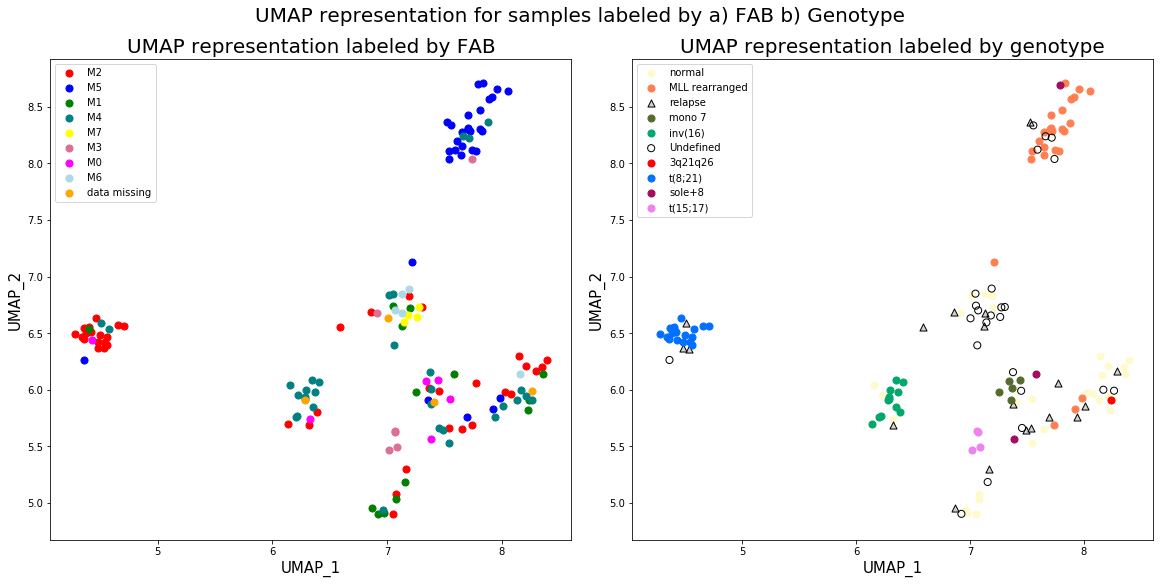

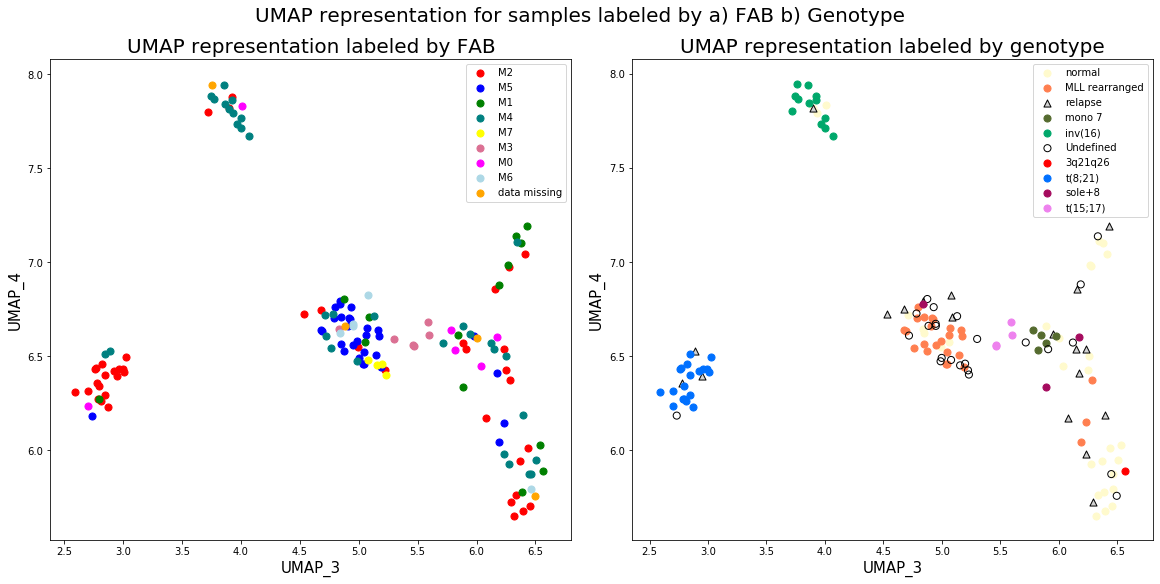

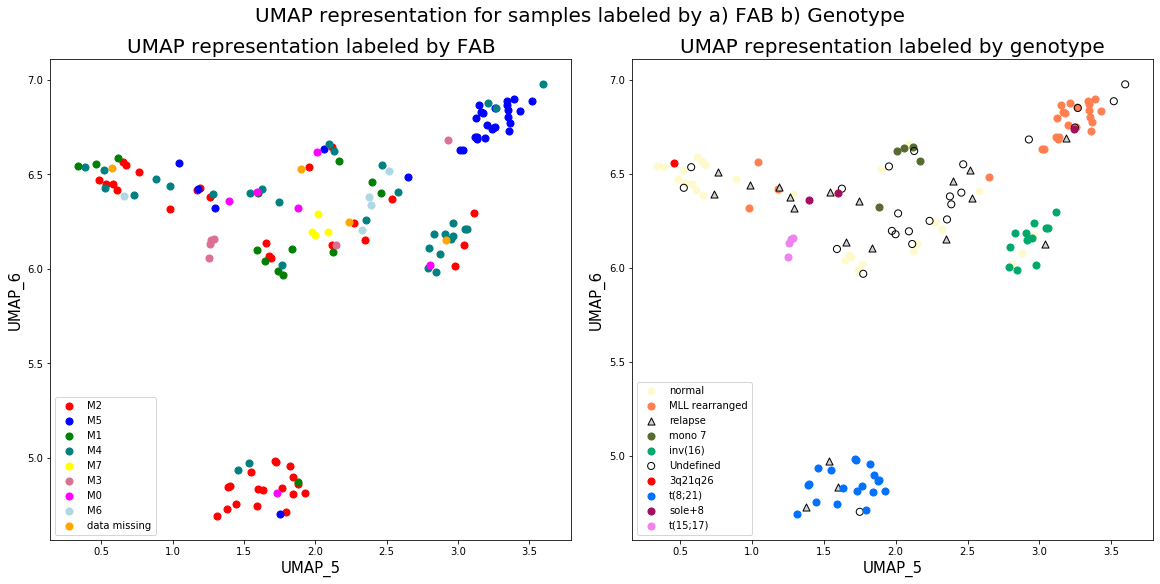

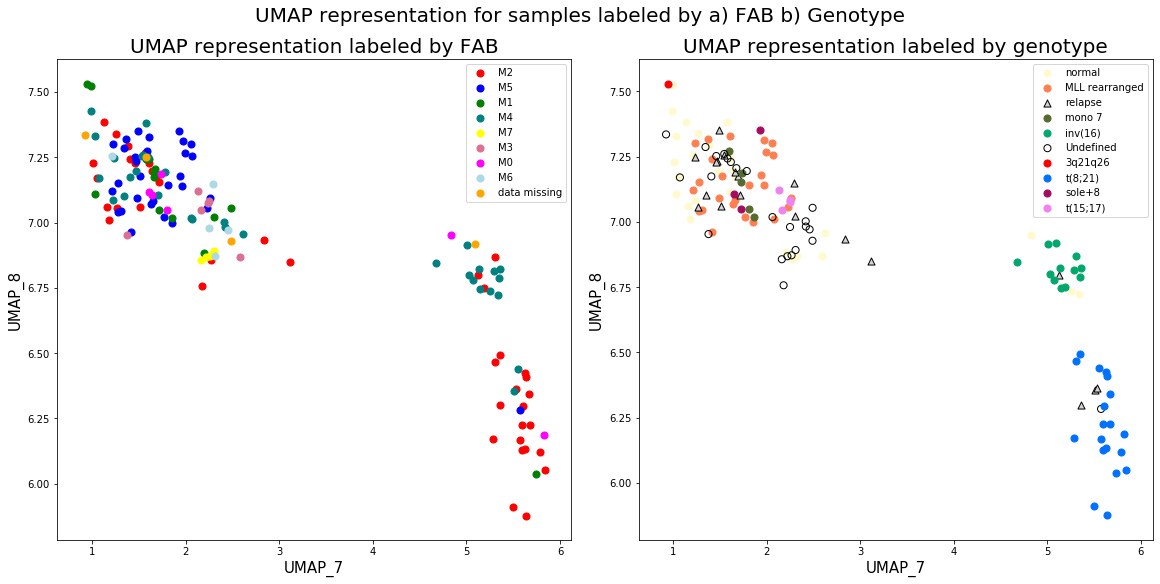

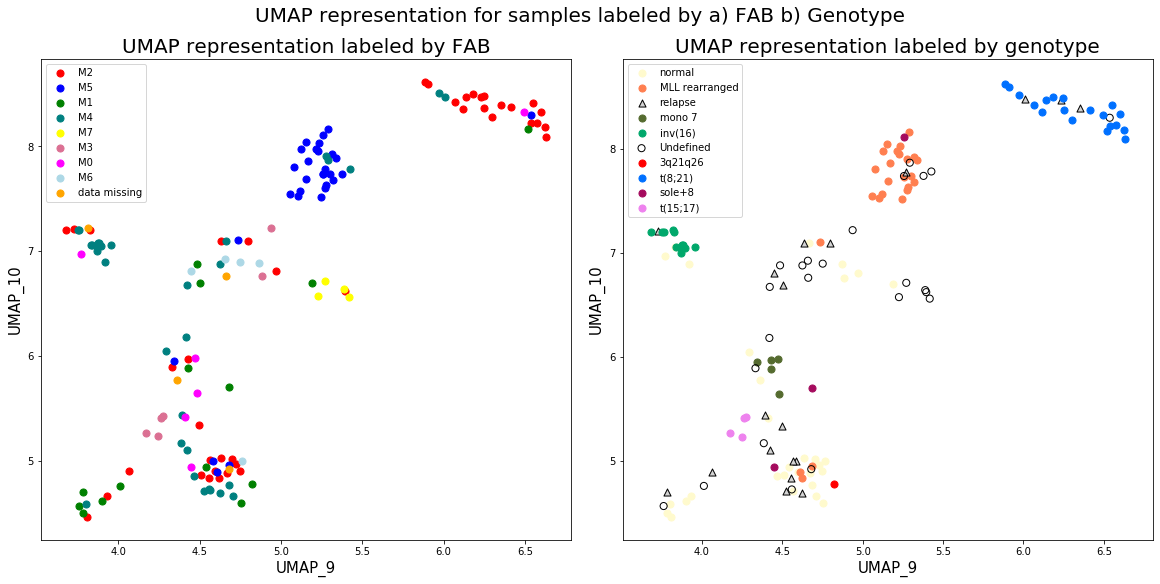

In [23]:
for comp in range(1, n_components + 1, 2): #step factor =2 so we compare 1-2, 3-4 etc.
    
    fig = plt.figure(constrained_layout=True, figsize = (16,8))
    widths = [18, 18]
    heights = [10]
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                                  height_ratios=heights)


    kplot = fig.add_subplot(spec[0,0])
    kplot.set_xlabel('UMAP_{}'.format(comp), fontsize = 15)
    kplot.set_ylabel('UMAP_{}'.format(comp + 1 ), fontsize = 15)
    kplot.set_title('UMAP representation labeled by FAB', fontsize = 20)
    clusterings = list(finaldf.FAB.unique())
    colorings = ['r', 'b', 'g', 'teal', 'yellow', 'palevioletred', 'magenta', 'lightblue', 'orange']
    
    for clustering, coloring in zip(clusterings, colorings):
        indicesToKeep = finaldf['FAB'] == clustering
        kplot.scatter(finaldf.loc[indicesToKeep, 'UMAP_{}'.format(comp)]
                   , finaldf.loc[indicesToKeep, 'UMAP_{}'.format(comp + 1)]
                   , c = coloring           
                   , s = 50)
    kplot.legend(clusterings)
    


    kplot2 = fig.add_subplot(spec[0,1])
    kplot2.set_xlabel('UMAP_{}'.format(comp), fontsize = 15)
    kplot2.set_ylabel('UMAP_{}'.format(comp + 1 ), fontsize = 15)
    kplot2.set_title('UMAP representation labeled by genotype', fontsize = 20)
    clusterings = list(finaldf.finalgenotype2.unique())
    
 
    
    for clustering, coloring in zip(clusterings, gencolor):
        indicesToKeep = finaldf['finalgenotype2'] == clustering
        if clustering == 'Undefined':
            kplot2.scatter(finaldf.loc[indicesToKeep, 'UMAP_{}'.format(comp)]
                   , finaldf.loc[indicesToKeep, 'UMAP_{}'.format(comp + 1)]
                   , c = 'none'           
                   , s = 50
                   , edgecolor = 'black')
            
        elif clustering == 'relapse':
            kplot2.scatter(finaldf.loc[indicesToKeep, 'UMAP_{}'.format(comp)]
                   , finaldf.loc[indicesToKeep, 'UMAP_{}'.format(comp + 1)]
                   , c = coloring
                   , marker = '^'
                   , s = 50
                   , edgecolor = 'black')
        else:  
            kplot2.scatter(finaldf.loc[indicesToKeep, 'UMAP_{}'.format(comp)]
                       , finaldf.loc[indicesToKeep, 'UMAP_{}'.format(comp + 1)]
                       , c = coloring           
                       , s = 50)
  
    kplot2.legend(clusterings)
    
    
    plt.suptitle('UMAP representation for samples labeled by a) FAB b) Genotype', fontsize = 20)
    #plt.subplots_adjust(hspace=0)
    plt.grid()
    kplot2.grid()
    plt.show()

# Heatmap & Hierarchical Clustering

In [24]:
import scipy.cluster.hierarchy as sch


In [25]:
def clust(data, phenodata):
    linkage = sch.linkage(data, method = 'ward')
    dendroSamples = sch.dendrogram(linkage, labels = data.index, no_plot = True)
    

    
    CPGlinkage = sch.linkage(data.T, method = 'ward')
    
    dendroCPG = sch.dendrogram(CPGlinkage, labels =data.T.index, no_plot = True)
    
    newindices = dendroSamples['ivl']
    orderedCPG = dendroCPG['ivl']
    
    # change the order of the methylation and phenotype dataframes
    
    Xfinal2 = data.copy()
  
    Xfinal3 = Xfinal2.reindex(newindices)
    
    
   
    
    phenodf2 = phenodata.copy()
    phenodf2 = phenodf2.reindex(newindices)
    

    # drop non necessary columns
    #Xfinal3.drop(['SampleID', 'IDs'], axis = 1, inplace = True)
    #phenodf2.drop(['id'], axis = 1, inplace = True)
    
    return  orderedCPG, Xfinal3, phenodf2, linkage, CPGlinkage

In [26]:
def create_HeatMap_labels(phenodata):
   
    
    # 1 relapse vs no relapse
    
    followup =  phenodata['relapse'].astype('category').cat.codes
    followdict = {}
    for g, c in zip(phenodata['relapse'].astype('category'),  phenodata['relapse'].astype('category').cat.codes):
        followdict[str(g)] = c
    sortedfollow= dict(sorted(followdict.items(), key=lambda item: item[1]))
    
    # 2 subtype
    
    subtypes = phenodata.finalgenotype.astype('category').cat.codes
    genodict = {}
    for g, c in zip(phenodata.finalgenotype.astype('category'),  phenodata.finalgenotype.astype('category').cat.codes):
        genodict[str(g)] = c
    sortedgeno = dict(sorted(genodict.items(), key=lambda item: item[1]))
    sortedgeno
    
    # 3 FAB
    
    FAB =  phenodata.FAB.astype('category').cat.codes
    fabdict = {}
    for g, c in zip(phenodata.FAB.astype('category'),  phenodata.FAB.astype('category').cat.codes):
        fabdict[str(g)] = c
    sortedfab = dict(sorted(fabdict.items(), key=lambda item: item[1]))
    sortedfab

    #Convert the data to 3-d arrays for data visualization with seaborn
    followup = np.tile(followup, (3,1))
    subtypes = np.tile(subtypes, (3,1))
    FAB = np.tile(FAB, (3,1))
    
 
    featurelist = [subtypes, FAB, followup]
    

    cbarlabels = [list(sortedgeno.keys()), list(sortedfab.keys()), list(sortedfollow.keys())] 
    
    return featurelist, cbarlabels
    

In [27]:
def AnnotHeatMap(widths, 
         heights, 
         ncols, 
         nrows, 
         dendrolabels,
         dendrolabels2,
         linkage,
         linkage2,
         biodatalist, 
         cmaplist, 
         biolabels, 
         data, 
         cbarllist,
         datalabel,
         x_ticks,
         title,
         figname,
         figsize = (20,8),
         shrink = 1,
         aspect = 5,
         save = False
         ):
   
   

    fig = plt.figure(constrained_layout=True, figsize = (figsize))
    widths = widths
    heights = heights
    spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                              height_ratios=heights)
    
    #add dendogram for samples
    ax0 = fig.add_subplot(spec[0,1])
    
    den = sch.dendrogram(linkage, labels = dendrolabels)
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.figure.axes[-1].yaxis.label.set_size(15)
    #ax0.set_ylabel('Euclidean distances')
    ax0.set_title(title, fontsize = 35)
    
    
    # For biological data
    for row, d, cmap, l, cbar in zip(range(1, nrows-1), biodatalist, cmaplist, biolabels, cbarllist):
        #print(cbar)
         
        ax = fig.add_subplot(spec[row, 1])
        cmapN = plt.get_cmap(cmap, len(cbar))
        sns.heatmap(d, cmap = cmapN , ax = ax, cbar_kws={'label': l, 'shrink':shrink, 'aspect':aspect})
        #ax.figure.axes[-1].yaxis.label.set_size(15)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(l)

        colorbar = ax.collections[0].colorbar 
        #colorbar.ax.tick_params(labelsize=15)
        colorbar.set_label(label=l,size=15)
        
        r = colorbar.vmax - colorbar.vmin 
        colorbar.set_ticks([colorbar.vmin + r / len(cbar) * (0.5 + i) for i in range(len(cbar))])
        colorbar.set_ticklabels(cbar) 

    # Plot the methylation DATAFRAME

    ax1 = fig.add_subplot(spec[nrows-1,ncols-1])
    #ax1.figure.axes[-1].yaxis.label.set_size(15)
    
    
    sns.heatmap(data.T, cmap = 'RdBu_r', ax = ax1, cbar_kws={'label': datalabel})
    
    colorbar2 = ax1.collections[0].colorbar 
        
    colorbar2.set_label(label=datalabel,size=15)
    datapoints = [float(h) + 0.5 for h in range(data.shape[0])]
    ax1.set_xticks(datapoints)
    ax1.set_xticklabels(x_ticks)
    
    
    
    ax1.set_xlabel('Patients', fontsize = 30)
    #ax1.set_yticklabels(data.columns.to_list(), rotation = 45)
    ax1.set_yticks([])
    #ax1.set_ylabel('CpG sites', fontsize = 16)
    
    
    #add dendogram for cpg sites
    ax2 = fig.add_subplot(spec[nrows-1,0])
    
    den2 = sch.dendrogram(linkage2, labels = dendrolabels2, orientation='left')
    ax2.set_yticks([])
    ax2.set_ylabel('CpG sites', fontsize = 30)
    
    
    
    plt.subplots_adjust(wspace=0, hspace=0)
    if save == True:
        plt.savefig(figname)
        #plt.savefig(figname, dpi = 300)

    plt.show()

# The list is reversed in the color bars so  they go as:
1. 3q21q6 - r
2. MLL - coral
3. Undefined -light gray
4. inversion 16 - jade (#00A86B)
5. mono 7 - Dark olive green (#556B2F)
6. normal - Lemon chiffon (#FFFACD)
7. sole + 8 - jazzberry jam (#A50B5E)
8. t(15;17) - lavender magenta (#EE82EE)
9. t(8;21) - brandeis blue (#0070FF)

In [28]:
sub_colors = ['r', 'coral', 'lightgray',  '#00A86B', '#556B2F', '#FFFACD', '#A50B5E', '#EE82EE', '#0070FF']

In [29]:
cmapsub = matplotlib.colors.ListedColormap(sub_colors)

In [30]:
fab_colors = ['r', 'coral',  '#00A86B', '#556B2F', '#FFFACD', '#A50B5E', '#EE82EE', '#0070FF', 'lightgray']
fabrelapse = matplotlib.colors. ListedColormap(fab_colors)

In [31]:
relapse_colors = ['lightgray', '#3CB371', '#800000']

In [32]:
cmaprelapse = matplotlib.colors. ListedColormap(relapse_colors)

In [33]:
cbartitle = 'DNA Methylation'

cmaplist = [cmapsub, fabrelapse, cmaprelapse]
labels = ['Subtype', 'FAB', 'Relapse']
title = 'Most important 1018 CpG sites for FMCA data prediction'

<ipython-input-27-52f21ba11b27>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(spec[row, 1])
<ipython-input-27-52f21ba11b27>:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(spec[nrows-1,ncols-1])
<ipython-input-27-52f21ba11b27>:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a 

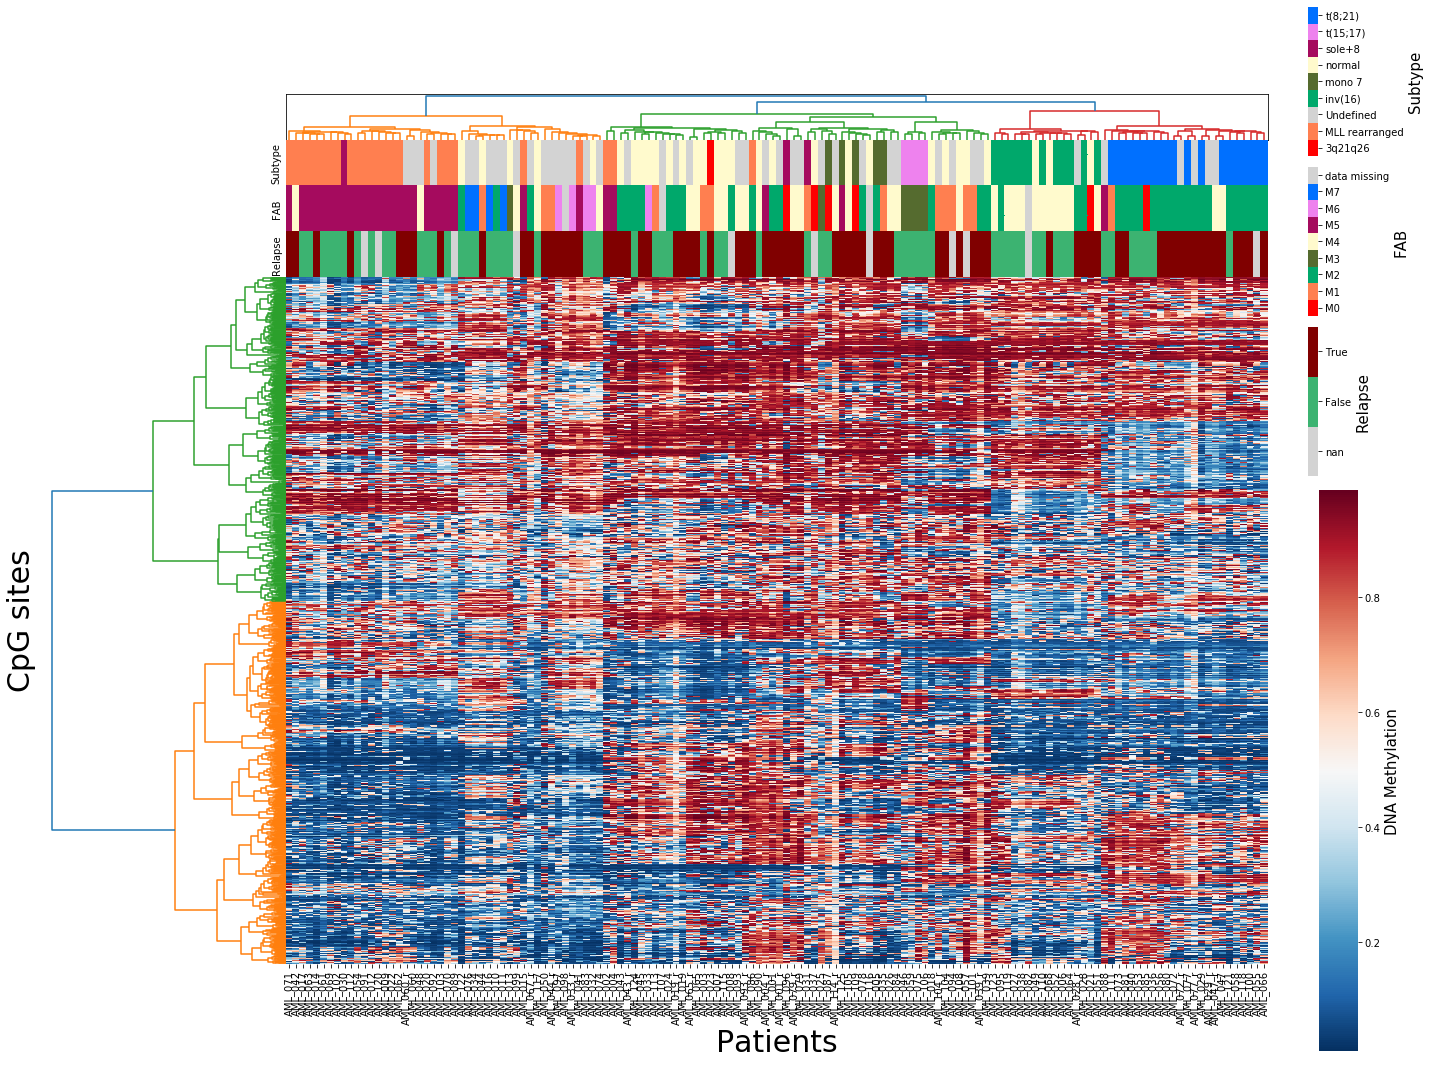

In [34]:
orderedCpG, Xfinal2, phenodf2, linkage, CPGlinkage = clust(Xfinal, phenodf)
    
# extract info about the annotated bars
featurelist, cbarlabels = create_HeatMap_labels(phenodf2)
data = Xfinal2[orderedCpG] # use the ordered 641 cpg sites from hierachical clustering
AnnotHeatMap(widths = [1, 4], heights = [1,1,1, 1, 15], ncols = 2, nrows = 5, linkage = linkage, linkage2 = CPGlinkage, 
             dendrolabels = data.index, dendrolabels2 = data.columns.to_list(),
             biodatalist=featurelist, 
             cmaplist = cmaplist, biolabels=labels, data = data, cbarllist=cbarlabels,datalabel=cbartitle,
             x_ticks =  data.index.to_list(),title=None,
             figname = 'HeatMap1300CpGs.png',
             figsize = (22,16),shrink = 4,aspect = 20,save = False)